# SIRD parameter learning using FISTA with terminal target

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2 + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3},
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameters $\theta$ and $\vartheta$ are non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, ones, allclose, arctan, exp, pi, append, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline, interp1d
from numpy.polynomial.chebyshev import chebpts1
from matplotlib.cm   import get_cmap

# Problem setup

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code
# Deceased rate
m = 0.1

In [5]:
ϑᵀᵉʳ = 0.01 * n
θ = 1e-4

## Generation of $\widehat \rho$

We are going to generate a choice for $\widehat\rho$ based on a solution of the system that satisfies the initial condition. For this, we find $\widehat\rho_{\mathsf e}$ as the solution of the SIR model for the choice $\alpha = (0.01,0.5)$. Then we will obtain $\widehat\rho = \widehat{\rho}_{\mathsf e} + 4\sin(\widehat{\rho}_{\mathsf e}) - 4\sin(\rho_0)$.

In [6]:
T  = 2.0                             # Final time
Tₑ = 0.5*(chebpts1(50000-2)+1) * T   # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])       # Add endpoints

In [7]:
# Rates for ρ̂ₑ:
βₑ, γₑ = 0.01, 0.5
αₑ = asarray([βₑ, γₑ])

In [8]:
print('Basic reproduction number:', n*βₑ/(γₑ+m))

Basic reproduction number: 3.3333333333333335


In [9]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [10]:
sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=(βₑ, γₑ), t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


In [11]:
ρ̂ₑ  = sol.y;    ρ = ρ̂ₑ.copy()
dρ̂ₑ = asarray(SIR(0,ρ̂ₑ,βₑ,γₑ))

Apply smooth transformation:

In [12]:
ρ̂ = ρ̂ₑ + 4*sin(ρ̂ₑ) - 4*sin(ρ̂ₑ[:,0])[::,np.newaxis]

This target is continuously differentiable, as we have that
\begin{align}
\frac{\dif }{\dif t} [y + 4\sin(y)] = y' + 4\cos(y) y'
\end{align}
hence, we can still use an Hermite interpolator.

In [13]:
dρ̂ = dρ̂ₑ + 4*cos(ρ̂ₑ)*dρ̂ₑ

Create an abstract interpolator for state:

In [14]:
ρₜ = CubicHermiteSpline(Tₑ, ρ̂ₑ, dρ̂ₑ, axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)
dρ̄ = interp1d(Tₑ, dρ̂, axis=-1)

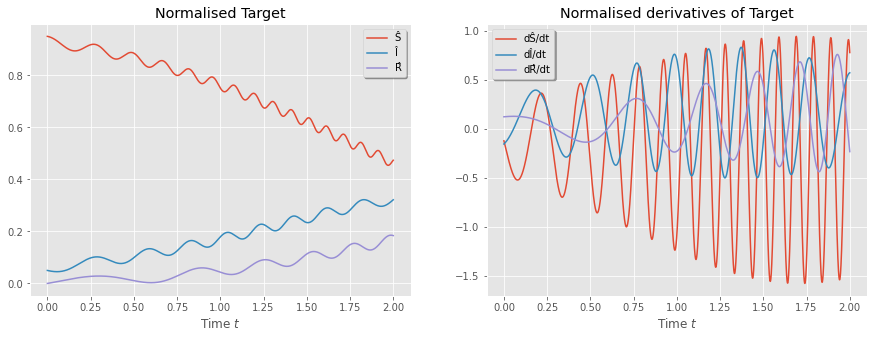

In [15]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, dρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dŜ/dt', 'dÎ/dt', 'dR̂/dt'], shadow=True)
plt.title('Normalised derivatives of Target')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = \vartheta\big[\rho(T) - \widehat{\rho}(T)\big]$.

Let us see how we can implement this with an adaptive step method:

In [16]:
def Adjoint(t, z, β,γ,ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [17]:
qₒ = ϑᵀᵉʳ*(ρ̂[:,-1] - ρ̂ₑ[:,-1])
solₛ = solve_ivp(Adjoint, [T,0], qₒ, args=(αₑ[0],αₑ[1],ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=True)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 128 function evaluations.


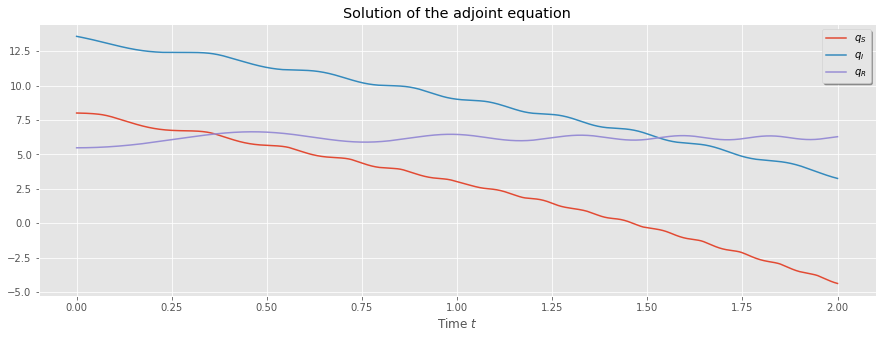

In [18]:
# Plot adjoint curves
plt.figure(figsize=(15,5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
#plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 ) + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3}.
\end{align}

In [19]:
α = αₑ.copy()

In [20]:
def Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ):    return 0.5 * (simpson((ρ-ρ̂)**2,Tₑ).sum() + θ * (α**2).sum()
                                                     + ϑᵀᵉʳ * ((ρ̂[:,-1] - ρ[:,-1])**2).sum() )

In [21]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [22]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,θ,ϑᵀᵉʳ) ))

As an example, the distance between ρ and ρ̂ is 61.4051.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma
\end{align}

In [23]:
q = solₛ.y[:,::-1]

In [24]:
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ) + θ * α[0], simpson(ρ[1] * (q[2]-q[1]), Tₑ) + θ * α[1]])
display(df.tolist())

[60225.89864217478, -86.95816391485188]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [25]:
def obj_eval_a(α):                # ** Eval just f ** #
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α,θ, ϑᵀᵉʳ)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)

In [26]:
# Coarse evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.00,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a( asarray([β,γ]) ).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [27]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.38553806729970264; (β,γ): 0.02 1.0


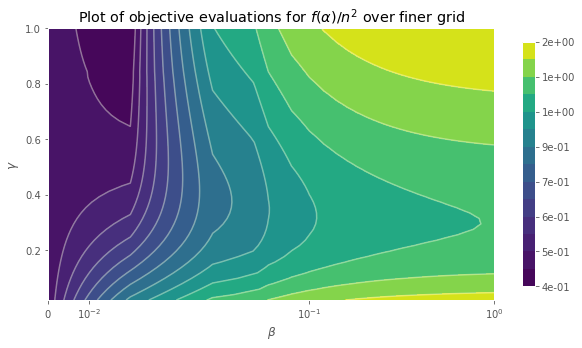

In [28]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('symlog', linthresh = 5e-2)
#plt.xscale('log')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

We want to see the efects of discretising the system over small grids, such that we can observe how this affects the objective and gradients attained. We must highlight here that these are the only affected quantities, as we use a fixed quadrature method on their computation, whereas the state and adjoint systems are computed using adaptive methods.

In [29]:
Nᴹᵃˣ = 50000   # Resolution of target

In [30]:
Nᴿᵃⁿᵍᵉ = asarray([50, 100, 500, 1000, 5000, 10000, 50000])

In [31]:
N = Nᴿᵃⁿᵍᵉ[0]

In [32]:
# Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],0.5*(chebpts1(N-2)+1) * T,[T]])

In [33]:
ρ̂  = ρ̄(Tₑ)           # Sample target
dρ̂ = dρ̄(Tₑ)          # Sample derivative of target (just for resolution of interporlator)

In [34]:
ρ̄ₙ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)        # Create interpolator for the sampled data

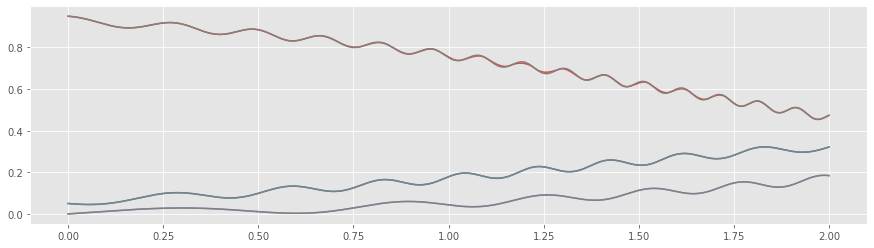

In [35]:
# We can see the differences between the ground truth and the interpolated curves:
Tᴹᵃˣ = concatenate([[0],0.5*(chebpts1(50000-2)+1) * T,[T]])
plt.figure(figsize=(15,4));   plt.plot(Tᴹᵃˣ, ρ̄ₙ(Tᴹᵃˣ).T/n);    plt.plot(Tᴹᵃˣ,  ρ̄(Tᴹᵃˣ).T/n, 'gray');    plt.show()

### Misfit with $\widehat{\rho}$

We will use a gradient-based algorithm for optimising $f$.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Fast Iterative Shrinkage-Thresholding Algorithm</h2>
<ol>
<li>Let $\alpha_0 = \omega_0 \in [0,1]^2$, $\theta_0 = 1$, $L_0>0$, $\eta > 1$, and $a < 1$.</li>
<li>
    For any $L>0$ and $\alpha,\omega \in [0,1]^2$, define the functions
    \begin{align}
        p_L (\omega) &= \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ],
    \\
        q_L (\omega,\alpha) &= f(\alpha) + \langle \omega-\alpha, \nabla f(\alpha) \rangle + \frac{L}{2} \|\omega-\alpha\|^2.
    \end{align}
</li>
    
<li>For $k \in \{0,\ldots\}$, do
<ol>
<li>Compute state $\rho_{\omega_k}$
<li>Compute adjoint $q_{\omega_k}$
<li>Evaluate the gradient of the reduced functional $ \nabla f(\omega_k)$

<li>Find the smallest $i_k \in \mathbb{N}$ such that
\begin{align}
    L &= \eta^{i_k} L_k
    \\
    f\big( p_L (\omega_k) \big) &\leq q_L \big( p_L(\omega_k), \omega_k  \big)
\end{align}
    
<li>Update $L_{k+1} = \eta^{i_k} L_k$
<li>Set $\alpha_{k+1} = p_{L_{k+1}} (\omega_k)$
<li>Update $\theta_{k+1} = a k + 1$
<li>Update $\omega_{k+1} = \alpha_{k+1} + \frac{\theta_k - 1}{\theta_{k+1}} (\alpha_{k+1} - \alpha_k)$
</li>
</ol>
</div>

Let's select a initial point at random:

In [36]:
β, γ = α = rng(0).uniform(0,1,2)

We will scale $\rho$ and $\widehat{\rho}$ by $n$.

In [37]:
def Adjoint(t, z, β,γ, ρ,ρ̄):
    S̄, Ī, R̄ = ρ̄(t)     # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

In [38]:
def Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ,Tₑ):    return 0.5 * (simpson((ρ-ρ̂)**2,Tₑ).sum() + θ * (α**2).sum()
                                                        + ϑᵀᵉʳ * ((ρ̂[:,-1] - ρ[:,-1])**2).sum() )

In [41]:
def FISTA(α, θ, ϑᵀᵉʳ, Tₑ, ρ̂, ρ̄ₙ,  iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 1e-9, try_TR = False):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'df_β':[], 'df_γ':[], 'Ter':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(ω)    |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    # Initialisation
    ω = α.copy()
    θₖ = 1.0      # Inertia parameter (not to be confused with \theta)
    η = 1.001     # Scaling for backtracking [!]
    L = 10.0#2.0#0.965     # Approximation of the Lipschitz constant [!]
    I = 20       # Number of iterations for backtracking
    a = 11.0/5   # Inertia weight (a > 2)
    
    # First objective evaluation
    # Compute state and adjoint for ω
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α,θ,ϑᵀᵉʳ,Tₑ)/(n**2)
    
    timed = 0.0
    for k in range(iters):
        #print(L)
        α_o = α.copy()
        θ_o = θₖ
        f_o = f
        
        it_time = time.time()
        
        # Compute state and adjoint for ω
        ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=ω, t_eval = Tₑ, 
                          dense_output=True, vectorized=True)
        if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
        ρ = ρ_sol.y
        f = Objective(ρ,ρ̂,ω,θ,ϑᵀᵉʳ,Tₑ) / (n**2)
        ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,ω[0],ω[1])), axis=-1)        # Interpolate state 
        
        # Compute adjoint
        qₒ = ϑᵀᵉʳ*(ρ[:,-1] - ρ̂[:,-1])       # Terminal condition of adjoint
        q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(ω[0], ω[1], ρₜ, ρ̄ₙ), t_eval = Tₑ[::-1], 
                          dense_output=True, vectorized=True)
        q = q_sol.y[:,::-1]
        
        # Compute derivative
        df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ), simpson(ρ[1] * (q[2]-q[1]), Tₑ)])
        df += (θ * ω)
        df /= (n**2)   # scaling
        
        # Store info for initial point
        if k == 0 and save_iter:
            every_iter['it'].append( k-1 )
            every_iter['obj'].append( f )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            every_iter['Ter'].append( norm( ρ̂[:,-1] - ρ_sol.y[:,-1] )/(3**0.5) )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( 0.5 * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        
        # Create scale factor is derivative is too far away from [0,1]^2:
        s  = 1.0/norm(df) if norm(df,np.inf) > 1.0 else 1.0 # [!]
        #s  = 0.1/norm(df) if norm(df,np.inf) > 1.0 else 1.0
        
        # Backtracking
        for i in range(I):
            # Temporary approximation of Lipschitz constant
            Lₓ = η**i * L
            b  = 1.0/Lₓ
            # Gradient and proximal step
            u = ω - (b * s) * df
            p = proj(u)
            # Compute state to validate Lₓ
            ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=p, t_eval = Tₑ, dense_output=True, vectorized=True)
            fₖ = Objective(ρ_sol.y,ρ̂,p,θ,ϑᵀᵉʳ,Tₑ)/(n**2)
            # Validation step
            if fₖ <= f + (p - ω).dot(df) + 0.5 * (Lₓ/s) * norm(p - ω)**2:
                break
        
        # Update control
        L = Lₓ
        α = p.copy()
        # Update inertia
        θₖ = ((k+1)/a) + 1.0
        ω = α + (θ_o - 1) * ( α - α_o )/θₖ
        if (ω < 0.0).any():
            #print('hey', ω)
            # Infeasible point is projected back into the box
            ω = proj(ω)
        
        Exit = True
        '''if L > 1e+4:
            print('Here')
            θₖ = (a/(k+1))
            η = 1.01     # Scaling for backtracking
            L = 0.965     # Approximation of the Lipschitz constant
            I = 20       # Number of iterations for backtracking
            a = 11.0/5   # Inertia weight (a > 2)
            #α = α_o.copy()
            α = ω.copy()
            Exit = False'''
            #break
        
                
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            every_iter['Ter'].append( norm( ρ̂[:,-1] - ρ_sol.y[:,-1] )/(3**0.5) )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( 0.5 * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(df)/(2**0.5) )
            every_critical['|df|_max'].append( norm(df,np.inf) )
            
            print('* {0:6.0f} |  {1:.3e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f, timed,
                                                                        norm(df)/(2**0.5), 
                                                                        norm(df,np.inf) ))
        
        if abs(f - f_o) < εₐ and k > 10:
            print('|f-fₖ| < {0:1.0e}'.format(εₐ))
            break
        
        if norm(α - α_o)/(2.0**0.5) < εᵦ:
            print('‖αₖ - p‖ < {0:1.0e}'.format(εᵦ))
            print(α)
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    return α, ρ, every_critical, every_iter

Run algorithm for the different choices of $N$:

In [44]:
Stats  = None
States = dict()

ϑᵀᵉʳ = 0.01*n
for N in Nᴿᵃⁿᵍᵉ:
    # Evaluation interval using Chebyshev points of the first kind
    Tₑ = concatenate([[0],0.5*(chebpts1(N-2)+1) * T,[T]])
    
    # Setup target
    ρ̂  = ρ̄(Tₑ)           # Sample target
    dρ̂ = dρ̄(Tₑ)          # Sample derivative of target (just for resolution of interporlator)
    ρ̄ₙ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)        # Create interpolator for the sampled data
    
    
    # Run algorithm
    print('–'*20, '{0}'.format(N), '–'*20, '\n\n')
    ᾱ, ρ, every_critical, every_iter = FISTA(α, θ, ϑᵀᵉʳ, Tₑ, ρ̂, ρ̄ₙ,   10000+1, 
                                             save_iter = True, critical = 100, εₐ = 1e-9, εᵦ = 1e-9, try_TR = False)


    # Recover dataframe from results
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)


    # Store info from iterate with smallest objective
    ArgMin_FISTA = df_every.idxmin()['obj']
    Out_N = df_every.loc[[ArgMin_FISTA]].rename(index={ArgMin_FISTA:N}).copy()
    
    # Recover state with smallest objective
    sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=(Out_N['β'].values.item(), Out_N['γ'].values.item()), 
                t_eval = Tₑ, dense_output=True, vectorized=True)
    
    ρ = sol.y
    #df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():N}).copy()
    Stats = pd.concat([Stats,Out_N])
    States[N] = ρ.copy()



–––––––––––––––––––– 50 –––––––––––––––––––– 


     It  |    f(ω)    |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  1.191e+00 |     0.03  | 1.274e-01   |   1.768e-01  
*    100 |  4.412e-01 |     1.66  | 1.730e+01   |   2.447e+01  
*    200 |  9.793e-01 |     2.86  | 2.679e+00   |   3.789e+00  
*    300 |  5.052e-02 |     3.78  | 3.096e+01   |   4.379e+01  
*    400 |  2.372e-01 |     4.52  | 4.021e+01   |   5.687e+01  
*    500 |  1.971e-02 |     5.68  | 1.409e+01   |   1.992e+01  
*    600 |  1.142e-02 |     6.96  | 2.185e+00   |   3.089e+00  
*    700 |  9.702e-03 |     8.06  | 4.376e-02   |   6.146e-02  
*    800 |  7.275e-03 |     8.51  | 5.150e-02   |   5.408e-02  
*    900 |  4.961e-03 |     8.95  | 3.187e-02   |   4.507e-02  
*   1000 |  3.138e-03 |     9.29  | 2.522e-02   |   3.473e-02  
*   1100 |  1.884e-03 |     9.78  | 1.689e-02   |   2.386e-02  
*   1200 |  1.184e-03 |    10.18  | 9.384e-03   |   1.327

*   5800 |  4.383e-01 |    17.60  | 1.492e+01   |   2.109e+01  
*   5900 |  4.383e-01 |    17.86  | 1.492e+01   |   2.111e+01  
*   6000 |  4.383e-01 |    18.12  | 1.493e+01   |   2.112e+01  
*   6100 |  4.383e-01 |    18.38  | 1.493e+01   |   2.111e+01  
*   6200 |  4.383e-01 |    18.63  | 1.492e+01   |   2.111e+01  
*   6300 |  4.383e-01 |    18.88  | 1.493e+01   |   2.111e+01  
*   6400 |  4.383e-01 |    19.14  | 1.494e+01   |   2.113e+01  
*   6500 |  4.383e-01 |    19.39  | 1.494e+01   |   2.113e+01  
*   6600 |  4.383e-01 |    19.65  | 1.493e+01   |   2.112e+01  
*   6700 |  4.382e-01 |    19.91  | 1.493e+01   |   2.112e+01  
*   6800 |  4.382e-01 |    20.16  | 1.494e+01   |   2.113e+01  
*   6900 |  4.382e-01 |    20.41  | 1.495e+01   |   2.114e+01  
*   7000 |  4.382e-01 |    20.66  | 1.494e+01   |   2.113e+01  
*   7100 |  4.382e-01 |    20.91  | 1.494e+01   |   2.113e+01  
*   7200 |  4.382e-01 |    21.17  | 1.494e+01   |   2.113e+01  
*   7300 |  4.382e-01 |    21.43  | 1.49

*   8200 |  4.363e-01 |    24.26  | 1.526e+01   |   2.158e+01  
*   8300 |  4.363e-01 |    24.51  | 1.527e+01   |   2.159e+01  
*   8400 |  4.363e-01 |    24.76  | 1.527e+01   |   2.159e+01  
*   8500 |  4.363e-01 |    25.01  | 1.526e+01   |   2.158e+01  
*   8600 |  4.363e-01 |    25.26  | 1.526e+01   |   2.159e+01  
*   8700 |  4.362e-01 |    25.51  | 1.527e+01   |   2.159e+01  
*   8800 |  4.362e-01 |    25.76  | 1.527e+01   |   2.160e+01  
*   8900 |  4.362e-01 |    26.02  | 1.527e+01   |   2.159e+01  
*   9000 |  4.362e-01 |    26.27  | 1.527e+01   |   2.159e+01  
*   9100 |  4.362e-01 |    26.52  | 1.527e+01   |   2.160e+01  
*   9200 |  4.362e-01 |    26.77  | 1.528e+01   |   2.160e+01  
*   9300 |  4.362e-01 |    27.02  | 1.527e+01   |   2.160e+01  
*   9400 |  4.362e-01 |    27.27  | 1.527e+01   |   2.160e+01  
*   9500 |  4.362e-01 |    27.52  | 1.527e+01   |   2.160e+01  
*   9600 |  4.362e-01 |    27.77  | 1.528e+01   |   2.161e+01  
*   9700 |  4.362e-01 |    28.02  | 1.52

*   8000 |  4.440e-01 |    34.75  | 1.359e+01   |   1.922e+01  
*   8100 |  4.440e-01 |    35.13  | 1.359e+01   |   1.922e+01  
*   8200 |  4.440e-01 |    35.52  | 1.359e+01   |   1.922e+01  
*   8300 |  4.440e-01 |    35.90  | 1.360e+01   |   1.923e+01  
*   8400 |  4.440e-01 |    36.28  | 1.360e+01   |   1.923e+01  
*   8500 |  4.440e-01 |    36.66  | 1.359e+01   |   1.923e+01  
*   8600 |  4.440e-01 |    37.04  | 1.359e+01   |   1.922e+01  
*   8700 |  4.440e-01 |    37.42  | 1.360e+01   |   1.923e+01  
*   8800 |  4.440e-01 |    37.80  | 1.360e+01   |   1.923e+01  
*   8900 |  4.440e-01 |    38.18  | 1.360e+01   |   1.923e+01  
*   9000 |  4.439e-01 |    38.56  | 1.360e+01   |   1.923e+01  
*   9100 |  4.439e-01 |    38.94  | 1.360e+01   |   1.923e+01  
*   9200 |  4.439e-01 |    39.32  | 1.360e+01   |   1.923e+01  
*   9300 |  4.439e-01 |    39.70  | 1.360e+01   |   1.924e+01  
*   9400 |  4.439e-01 |    40.08  | 1.360e+01   |   1.924e+01  
*   9500 |  4.439e-01 |    40.45  | 1.36

In [45]:
#CMap = get_cmap('Wistia')
CMap = get_cmap('RdPu')
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

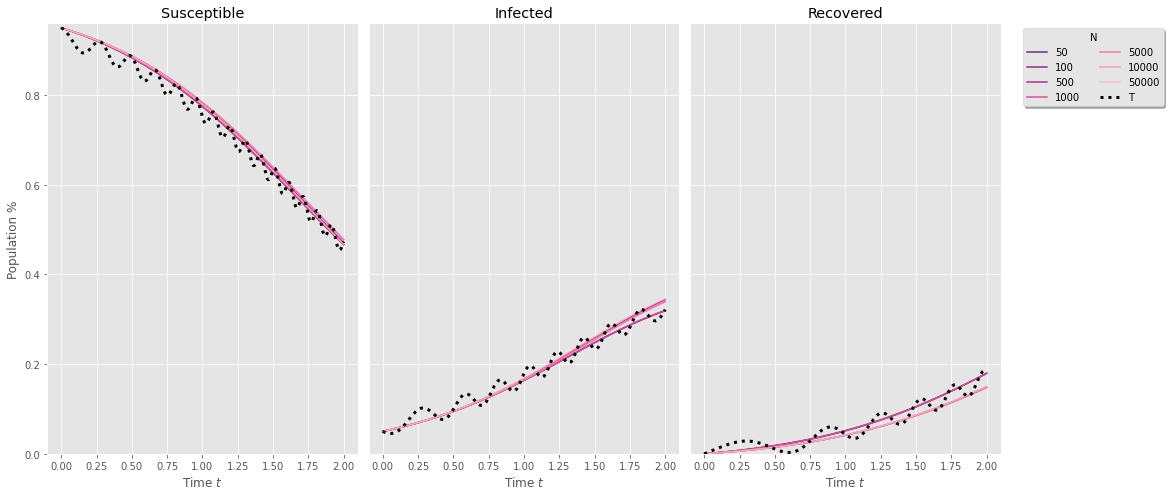

In [46]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for N, ρ in States.items():
    Tₑ = concatenate([[0],0.5*(chebpts1(N-2)+1) * T,[T]])
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0}'.format(N))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0}'.format(N))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0}'.format(N))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='N')
fig.tight_layout()
plt.savefig('Outputs/Grid – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

[]

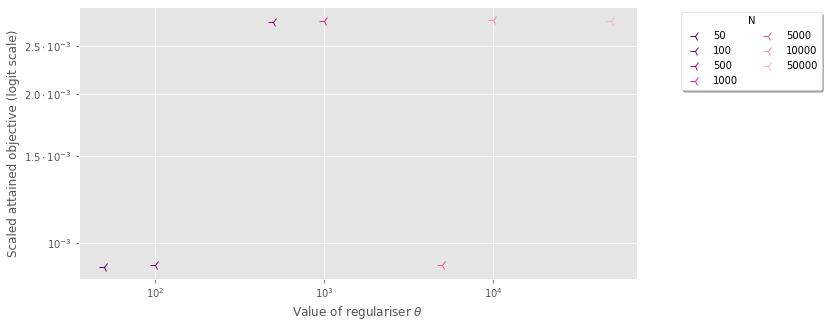

In [47]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for N, fᵥ in Stats['obj'].iteritems():
    
    # Susceptible
    plt.plot(N, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='3', linestyle = '', markersize=10, 
             label = '{0}'.format(N))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='N')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

Compute finer mesh:

In [48]:
Tₑ = concatenate([[0],0.5*(chebpts1(50000-2)+1) * T,[T]])

In [49]:
def obj_eval_a(α):                # ** Eval just f ** #
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α,θ, ϑᵀᵉʳ, Tₑ)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)

In [50]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,1.0,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [51]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.03622995934549353; (β,γ): 0.013333333333333334 0.9803999999999999


Plot of objective evaluations for f(α)/n² over finer grid


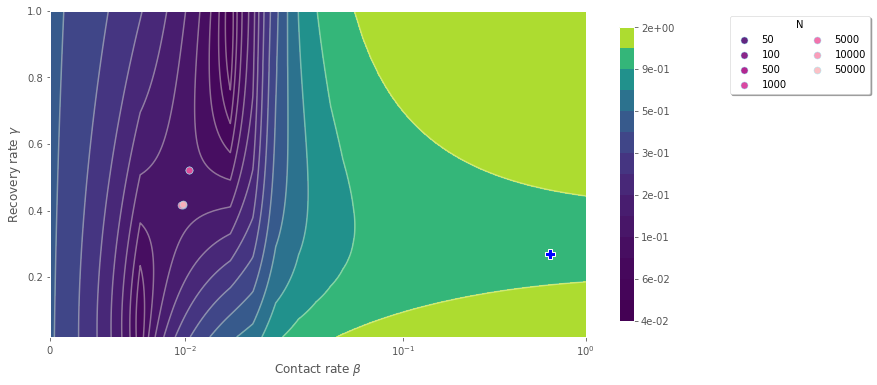

In [52]:
# Contour plot
print('Plot of objective evaluations for f(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )

# Approximate minimisers
k_row = colours_GD.shape[0] - 1
# Approximate minimisers
for row in Stats.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row], edgecolor = "xkcd:robin's egg blue",
         alpha =0.85, marker='.', s = 200, label = '{0}'.format(N))

    k_row -= 1
    

ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='N')
plt.show()
#fig.savefig('Outputs/Grid – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Compute finer mesh around minimisers:

In [53]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,0.02,nβ)
γ_axis = linspace(0.0,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [54]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.0009160903490674993; (β,γ): 0.010266666666666667 0.5133333333333334


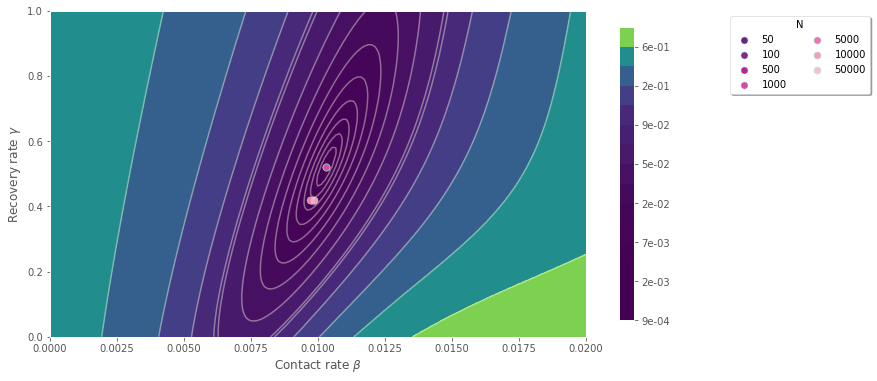

In [55]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = append( 0.086, np.logspace( np.log( Misfit[Misfit>0.0].min() ), np.log( Misfit.max() ), 
                num=15, endpoint=True, base=np.e) )
ℓ.sort()

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot


# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    N = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row], edgecolor = "xkcd:robin's egg blue",
         alpha =0.85, marker='.', s = 200, label = '{0}'.format(N))

    k_row -= 1




fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='N')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

---

In [56]:
Stats

,it,obj,time,β,γ,df_β,df_γ,Ter,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
50,1339,0.000897,11.133460,0.010311,0.521248,-0.023557,1.075104e-04,0.985154,0.011832,0.016657,0.023557,1.075104e-04
100,2555,0.000905,17.841580,0.010312,0.521215,0.000006,-3.409263e-06,0.986374,0.000004,0.000005,0.000006,3.409263e-06
500,211,0.002789,3.325432,0.009804,0.417468,16.825558,-8.097395e-02,4.763125,8.453266,11.897604,16.825558,8.097395e-02
1000,211,0.002807,3.467929,0.009729,0.418087,17.021462,-8.180546e-02,4.679672,8.551634,12.036130,17.021462,8.180546e-02
5000,1388,0.000905,14.753981,0.010312,0.521236,0.000077,-5.514926e-07,0.986607,0.000039,0.000054,0.000077,5.514926e-07
10000,211,0.002827,4.269357,0.009719,0.418023,17.030958,-8.218898e-02,4.688615,8.556574,12.042846,17.030958,8.218898e-02
50000,213,0.002811,12.384790,0.009850,0.418166,16.905040,-7.891997e-02,4.837193,8.491980,11.953798,16.905040,7.891997e-02


In [57]:
Stats.to_pickle('Outputs/Grid – FISTA - Final.pkl') # To read back use pd.read_pickle(file_name)

---